PyMC3 intro paper: https://github.com/pymc-devs/pymc3/blob/master/docs/source/notebooks/getting_started.ipynb

In [57]:
# GENERATING DATA
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

Matplotlib is building the font cache using fc-list. This may take a moment.


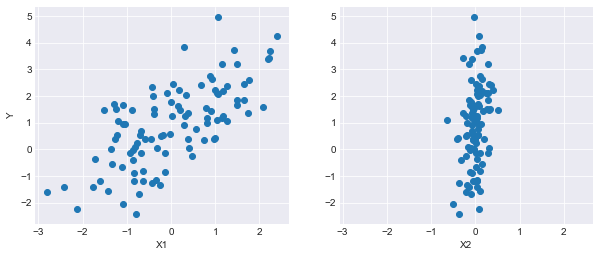

In [58]:
%matplotlib inline 

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

In [59]:
import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.8


In [61]:
basic_model = pm.Model() #creates a new Model object which is a container for the model random variables.


with basic_model: 
#creates a context manager, with our basic_model as the context, that includes all statements until the indented block ends.
#This means all PyMC3 objects introduced in the indented code block below the with statement are added to the model behind the scenes. Absent this context manager idiom, we would be forced to manually associate each of the variables with basic_model right after we create them. If you try to create a new random variable without a with model: statement, it will raise an error since there is no obvious model for the variable to be added to.    

# Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10) #first argument is name of random variable, should always match python variable assigned to it
    beta = pm.Normal('beta', mu=0, sigma=10, shape=2) #shape specifies size of random vector, default is 1
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2
    '''
    This creates a deterministic random variable,
    which implies that its value is completely determined by its parents' values.
    That is, there is no uncertainty beyond
    that which is inherent in the parents' values.
    Here, mu is just the sum of the intercept alpha
    and the two products of the coefficients in beta
    and the predictor variables, whatever their values may be.
    '''
    
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)
    '''
    This is a special case of a stochastic variable that we call an observed stochastic, and represents the data likelihood of the model. It is identical to a standard stochastic, except that its observed argument, which passes the data to the variable, indicates that the values for this variable were observed, and should not be changed by any fitting algorithm applied to the model. The data can be passed in the form of either a numpy.ndarray or pandas.DataFrame object.

    Notice that, unlike for the priors of the model, the parameters for the normal distribution of Y_obs are not fixed values, but rather are the deterministic object mu and the stochastic sigma. This creates parent-child relationships between the likelihood and these two variables.
    '''
    

In [63]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2417.12draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13e737a90>,
      dtype=object)

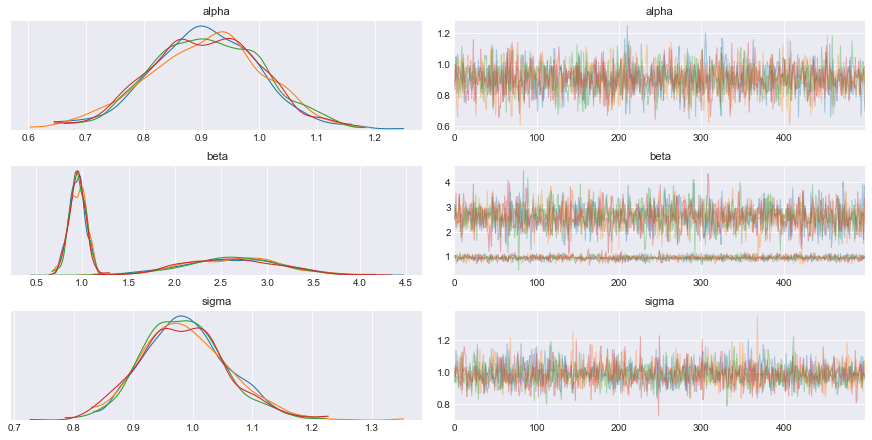

In [64]:
pm.traceplot(trace)

In [65]:
pm.summary(trace).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.91,0.10,0.72,1.09,0.00,0.00,2896.0,2873.0,2887.0,1404.0,1.00
beta[0],0.95,0.09,0.78,1.12,0.00,0.00,3060.0,3060.0,3072.0,1807.0,1.01
beta[1],2.61,0.52,1.68,3.58,0.01,0.01,2749.0,2671.0,2766.0,1635.0,1.00
sigma,0.99,0.07,0.85,1.12,0.00,0.00,2952.0,2902.0,2966.0,1739.0,1.00


tutorial: http://barnesanalytics.com/bayesian-logistic-regression-in-python-using-pymc3

dataset https://www.huduser.gov/portal/datasets/hads/hads2013n_ASCII.zip

In [53]:
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import theano.tensor as t
from scipy.stats import mode
def tinvlogit(x):
    return t.exp(x) / (1 + t.exp(x))

In [55]:
df=pd.read_csv('input/thads2013n.txt',sep=',') 
df=df[df['BURDEN']>0]
df=df[df['AGE1']>0]
df['OWN']=[1 if obj=='2' else 0 for obj in df['OWNRENT']]
df

,CONTROL,AGE1,METRO3,REGION,LMED,FMR,L30,L50,L80,IPOV,BEDRMS,BUILT,STATUS,TYPE,VALUE,...,FMTCOST06RELFMRCAT,FMTCOST08RELFMRCAT,FMTCOST12RELFMRCAT,FMTCOSTMEDRELFMRCAT,FMTINCRELFMRCAT,FMTCOST06RELAMICAT,FMTCOST08RELAMICAT,FMTCOST12RELAMICAT,FMTCOSTMEDRELAMICAT,FMTINCRELAMICAT,FMTASSISTED,FMTBURDEN,FMTREGION,FMTSTATUS,OWN
0,'100003130103',82,'3','1',73738,956,15738,26213,40322,11067,2,2006,'1',1,40000,...,'2 50.1 - 100% FMR','2 50.1 - 100% FMR','2 50.1 - 100% FMR','2 50.1 - 100% FMR','1 LTE 50% FMR','2 30 - 50% AMI','2 30 - 50% AMI','2 30 - 50% AMI','2 30 - 50% AMI','2 30 - 50% AMI','.','2 30% to 50%','-5','-5',0
1,'100006110249',50,'5','3',55846,1100,17165,28604,45744,24218,4,1980,'1',1,130000,...,'3 GT FMR','3 GT FMR','3 GT FMR','2 50.1 - 100% FMR','3 GT FMR','4 60 - 80% AMI','4 60 - 80% AMI','6 100 - 120% AMI','4 60 - 80% AMI','7 120% AMI +','.','1 Less than 30%','-5','-5',0
2,'100006370140',53,'5','3',55846,1100,13750,22897,36614,15470,4,1985,'1',1,150000,...,'3 GT FMR','3 GT FMR','3 GT FMR','2 50.1 - 100% FMR','2 50.1 - 100% FMR','4 60 - 80% AMI','5 80 - 100% AMI','6 100 - 120% AMI','4 60 - 80% AMI','4 60 - 80% AMI','.','3 50% or More','-5','-5',0
3,'100006520140',67,'5','3',55846,949,13750,22897,36614,13964,3,1985,'1',1,200000,...,'3 GT FMR','3 GT FMR','3 GT FMR','3 GT FMR','2 50.1 - 100% FMR','6 100 - 120% AMI','7 120% AMI +','7 120% AMI +','5 80 - 100% AMI','4 60 - 80% AMI','.','1 Less than 30%','-5','-5',0
4,'100007130148',26,'1','3',60991,737,14801,24628,39421,15492,2,1980,'1',1,-6,...,'3 GT FMR','3 GT FMR','3 GT FMR','3 GT FMR','3 GT FMR','3 50 - 60% AMI','3 50 - 60% AMI','3 50 - 60% AMI','3 50 - 60% AMI','7 120% AMI +','0 Not Assisted','1 Less than 30%','-5','-5',0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64528,'999900056776',71,'1','3',38500,652,10650,17700,28300,11080,2,1970,'1',1,-6,...,'1 LTE 50% FMR','1 LTE 50% FMR','1 LTE 50% FMR','1 LTE 50% FMR','1 LTE 50% FMR','1 LTE 30% AMI','1 LTE 30% AMI','1 LTE 30% AMI','1 LTE 30% AMI','1 LTE 30% AMI','0 Not Assisted','2 30% to 50%','-5','-5',0
64529,'999900056778',32,'2','1',105900,1285,22250,37100,52150,12071,1,1930,'1',1,-6,...,'3 GT FMR','3 GT FMR','3 GT FMR','3 GT FMR','2 50.1 - 100% FMR','5 80 - 100% AMI','5 80 - 100% AMI','5 80 - 100% AMI','5 80 - 100% AMI','3 50 - 60% AMI','0 Not Assisted','2 30% to 50%','-5','-5',0
64530,'999900056779',55,'1','4',55929,556,12938,21525,34414,12019,1,1930,'1',1,-6,...,'3 GT FMR','3 GT FMR','3 GT FMR','3 GT FMR','1 LTE 50% FMR','3 50 - 60% AMI','3 50 - 60% AMI','3 50 - 60% AMI','3 50 - 60% AMI','1 LTE 30% AMI','0 Not Assisted','3 50% or More','West','-5',0
64532,'999900056784',23,'2','4',86300,2701,23500,39200,62650,15517,3,1940,'1',1,-6,...,'2 50.1 - 100% FMR','2 50.1 - 100% FMR','2 50.1 - 100% FMR','2 50.1 - 100% FMR','1 LTE 50% FMR','5 80 - 100% AMI','5 80 - 100% AMI','5 80 - 100% AMI','5 80 - 100% AMI','3 50 - 60% AMI','0 Not Assisted','3 50% or More','West','-5',0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [price, x, Intercept]
Sampling 4 chains, 3,710 divergences: 100%|██████████| 14000/14000 [01:05<00:00, 212.35draws/s]
There were 1016 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1003 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7146278562699208, but should be close to 0.8. Try to increase the number of tuning steps.
There were 969 divergences after tuning. Increase `target_accept` or reparameterize.
There were 720 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x139ad29e8>,
      dtype=object)

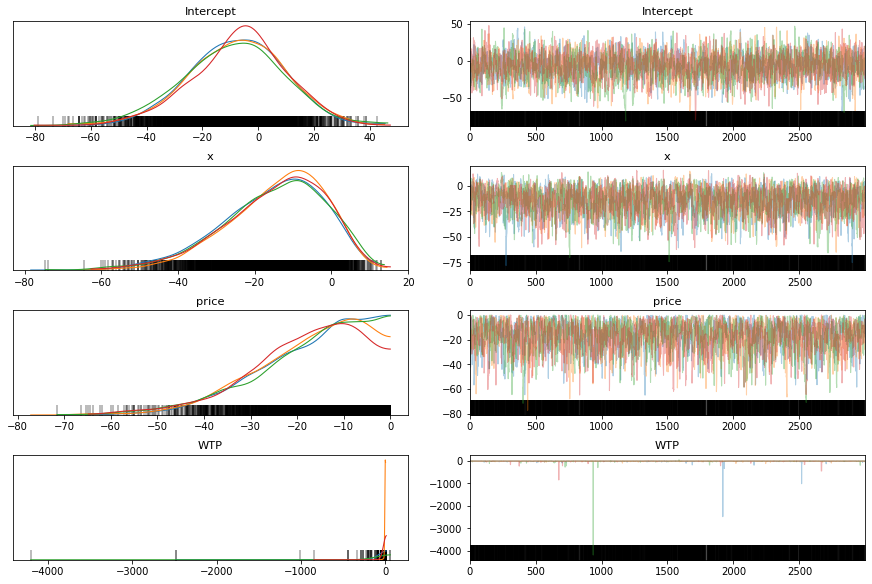

In [56]:
with pm.Model() as model: 
    # Define priors
    intercept = pm.Normal('Intercept', 0, sd=20)
    x_coeff = pm.Normal('x', 0, sd=20)
    price_coef = pm.Normal('price', 0, sd=20)
    
    # Define likelihood
    likelihood = pm.Bernoulli('y', 
                              pm.math.sigmoid(intercept+x_coeff*df['BEDRMS']+price_coef*df['COSTMED']),
                              observed=df['OWN'])
    WTP=pm.Deterministic('WTP',-x_coeff/price_coef)

    # Inference!
    trace = pm.sample(3000)
    
pm.traceplot(trace)

In [ ]:
pm.traceplot(trace)
plt.show()

tutorial: https://towardsdatascience.com/building-a-bayesian-logistic-regression-with-python-and-pymc3-4dd463bbb16

dataset: https://www.kaggle.com/janiobachmann/bank-marketing-dataset     

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import matplotlib.lines as mlines
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
import theano
import theano.tensor as tt
import itertools
from IPython.core.pylabtools import figsize
pd.set_option('display.max_columns', 30)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [18]:
df = pd.read_csv('input/bank.csv')
df.insert(0, 'y', 0)
df.loc[df.deposit == 'yes','y'] = 1
df.drop(columns='deposit', inplace = True)
df

,y,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,1,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown
1,1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown
2,1,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown
3,1,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown
4,1,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,0,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown
11158,0,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown
11159,0,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown
11160,0,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure


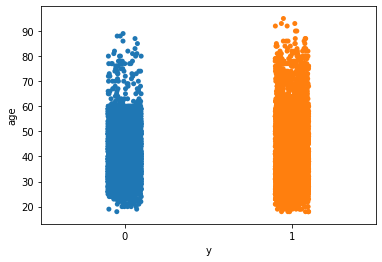

In [19]:
sns.stripplot(x=df.y, y=df.age, data=df, jitter=True)
plt.show()

In [52]:
sns.stripplot(x=df.y, y=df.euribor3m, data=df, jitter=True)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'euribor3m'

In [10]:
#import sys
#!{sys.executable} -m pip install pymc3

# Initial Model Sampling 

In [20]:
from input.heart_import import get_heart_data
from als import ALS

In [21]:
data = get_heart_data()

heart data import succesful


In [23]:
als = ALS(data)

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
lr = LogisticRegression(solver='liblinear', max_iter = 1000)

In [26]:
X, y = ALS.get_X_y(data)

In [27]:
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
lr.coef_

array([[ 0.00700256, -1.05512922, -0.01319276, -0.00357188,  0.14781383,
         0.44767165,  0.02189099, -0.74981946, -0.43853515, -0.76639704,
         0.65794178,  1.44474795,  1.26205239,  0.35834694,  0.71267192,
        -0.68163993, -0.46638697,  0.27983726]])

In [29]:
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [38]:
subset = X.sample(n=50)

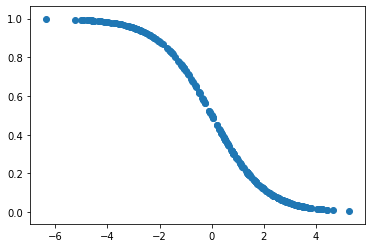

In [49]:
plt.scatter(lr.decision_function(X), lr.predict_proba(X)[:,0])

In [45]:
np.abs(lr.predict_proba(subset)[:,0] - 0.5)

array([0.24468046, 0.38870495, 0.14354637, 0.40962313, 0.44825284,
       0.24272286, 0.2306449 , 0.32338756, 0.45007512, 0.47109191,
       0.14984302, 0.43751908, 0.1860739 , 0.39839281, 0.25776954,
       0.44850432, 0.30826689, 0.09796193, 0.11661505, 0.39596316,
       0.42727283, 0.49067417, 0.04764058, 0.09178999, 0.45617051,
       0.02275376, 0.44240161, 0.21759708, 0.00927451, 0.25218978,
       0.48944038, 0.48926337, 0.07997843, 0.37167232, 0.39366658,
       0.00064813, 0.46143947, 0.47052667, 0.37557373, 0.14873933,
       0.45703718, 0.48441442, 0.02482961, 0.19814985, 0.46624314,
       0.47624175, 0.33271373, 0.46229583, 0.33537118, 0.47102793])

In [50]:
lr.coef_

array([[ 0.00700256, -1.05512922, -0.01319276, -0.00357188,  0.14781383,
         0.44767165,  0.02189099, -0.74981946, -0.43853515, -0.76639704,
         0.65794178,  1.44474795,  1.26205239,  0.35834694,  0.71267192,
        -0.68163993, -0.46638697,  0.27983726]])

In [51]:
lr.intercept_

array([0.15605694])